# SINDy weak form PDE find

An interactive version of this notebook is available on binder:   [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/urban-fasel/I-X_workshop_2025/HEAD?labpath=6_weak_SINDy_PDE.ipynb)

Kuramoto-Sivashinsky equation:  $u_t = -uu_x - u_{xx} - u_{xxxx}$

Data and code from PySINDy tutorial: 
- https://github.com/dynamicslab/pysindy/blob/master/examples/12_weakform_SINDy_examples.ipynb

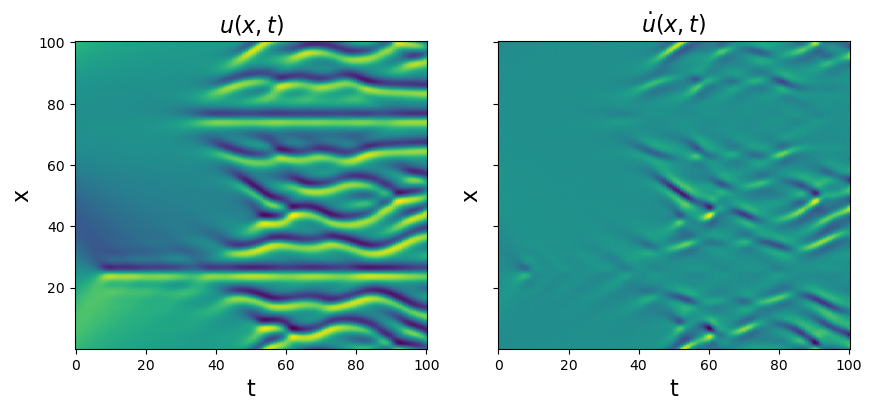

In [1]:
import pysindy as ps
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

poly_library = ps.PolynomialLibrary()
library_functions = [lambda x: abs(x+1.0), lambda x: abs(x-1)]
custom_lib = library_functions + poly_library

model = ps.SINDy(feature_library=custom_lib)

# Load data from .mat file
data = loadmat('data/KS_data.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
dt = t[1] - t[0]
dx = x[1] - x[0]

# Add Gaussian white noise to the data
np.random.seed(1)
sig = 0.0 # You can adjust the noise level here
sig = 0.01 # You can adjust the noise level here
u = u + sig * np.std(u) * np.random.randn(u.shape[0], u.shape[1])

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

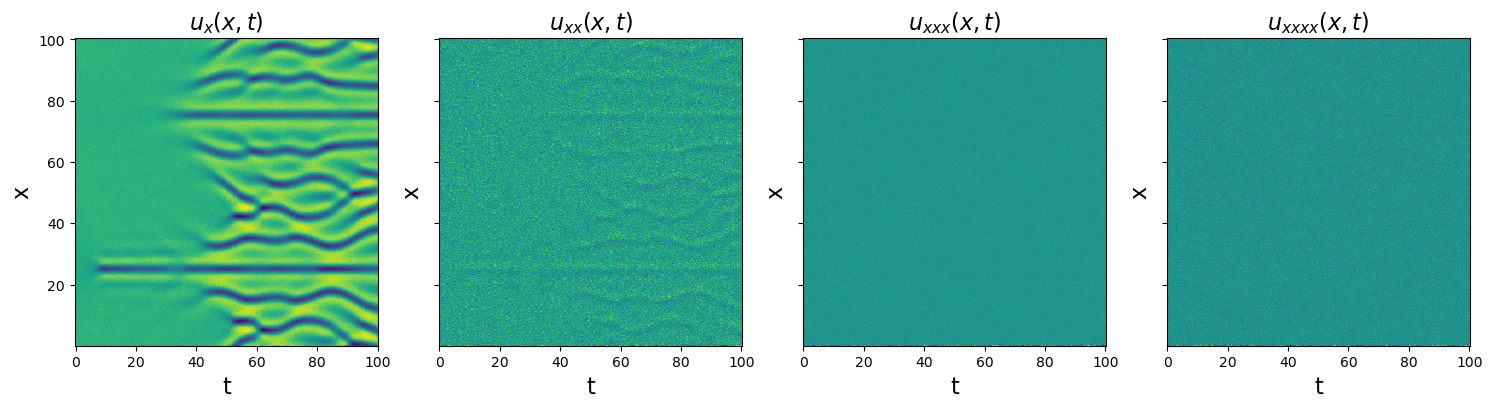

In [2]:
# plot spatial derivatives

ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)
uxxxx = ps.FiniteDifference(d=4, axis=0)._differentiate(u, dx)
    
# Plot derivative results
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.pcolormesh(t, x, ux[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.subplot(1, 4, 2)
plt.pcolormesh(t, x, uxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 3)
plt.pcolormesh(t, x, uxxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 4)
plt.pcolormesh(t, x, uxxxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxxx}(x, t)$', fontsize=16)
plt.show()

In [3]:
# Define PDE library that is quadratic in u, and 
# fourth-order in spatial derivatives of u.
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatial_grid=x
)
# include_bias : default False in PDElibrary, but default True in PolynomialLibrary
#        If True, then include a bias column, the feature in which
#        all polynomial powers are zero (i.e. a column of ones - acts as an
#        intercept term in a linear model).

# identify PDE
# here we use sequentially thresholded ridge regression (alpha=1e-5), and normalize the columns
optimizer = ps.STLSQ(threshold=10, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt, feature_names=["u"])

# # print library
# print("PDE SINDy library: ")
# print(pde_lib.get_feature_names(["u"]))

# print identified PDE
print("Identified PDE: ")
model.print()


Identified PDE: 
(u)' = 0.010 u_11 + -0.074 uu_1


In [4]:
# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Define weak form library
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT, 
    K=1000 # number of domains (default 100)
)

# identify PDE
model = ps.SINDy(feature_library=pde_lib)
model.fit(u, t=dt, feature_names=["u"])

# print identified PDE
print("Identified PDE using weak form SINDy: ")
model.print()

Identified PDE using weak form SINDy: 
(u)' = -0.998 u_11 + -1.000 u_1111 + -1.002 uu_1
